Supreme Court Judgement Prediction

https://www.kaggle.com/code/raghavkachroo/supreme-court-judgement-prediction

In [2]:
#!pip install CatBoost

## imports

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
import joblib
from joblib import dump, load

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import f1_score


from sklearn.metrics import accuracy_score
## for data

import re
import nltk # Natural Language Toolkit - пакет библиотек и программ для символьной и статистической обработки естественного языка
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import wordcloud

import gensim.downloader as gensim_api
import gensim

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/home/marina/miniforge3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[nltk_data] Downloading package punkt to /home/marina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/marina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/marina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# justice.csv

In [4]:
# !unzip -q /content/drive/MyDrive/My_Notebooks/RANEPA/judgement_prediction/justice.csv.zip -d /content/drive/MyDrive/My_Notebooks/RANEPA/judgement_prediction/
#df = pd.read_csv('../input/supreme-court-judgment-prediction/justice.csv', delimiter=',', encoding = "utf8")

# загружаем (читаем) датафрейм с юридическими прецедентами:
df_init = pd.read_csv('justice.csv', delimiter=',', encoding = "utf8") #/content/drive/MyDrive/My_Notebooks/RANEPA/judgement_prediction/
# смотрим размер таблицы:
print(df_init.shape)

(3303, 16)


In [46]:
# сделаем копию df_init, чтобы изменять и работать с данными: 
df = df_init.copy()
df.head(5)

,Unnamed: 0,ID,name,href,docket,term,first_party,second_party,facts,facts_len,majority_vote,minority_vote,first_party_winner,decision_type,disposition,issue_area
1,1,50613,Stanley v. Illinois,https://api.oyez.org/cases/1971/70-5014,70-5014,1971,"Peter Stanley, Sr.",Illinois,<p>Joan Stanley had three children with Peter ...,757,5,2,True,majority opinion,reversed/remanded,Civil Rights
2,2,50623,Giglio v. United States,https://api.oyez.org/cases/1971/70-29,70-29,1971,John Giglio,United States,<p>John Giglio was convicted of passing forged...,495,7,0,True,majority opinion,reversed/remanded,Due Process
3,3,50632,Reed v. Reed,https://api.oyez.org/cases/1971/70-4,70-4,1971,Sally Reed,Cecil Reed,"<p>The Idaho Probate Code specified that ""male...",378,7,0,True,majority opinion,reversed/remanded,Civil Rights
4,4,50643,Miller v. California,https://api.oyez.org/cases/1971/70-73,70-73,1971,Marvin Miller,California,"<p>Miller, after conducting a mass mailing cam...",305,5,4,True,majority opinion,vacated/remanded,First Amendment
5,5,50644,Kleindienst v. Mandel,https://api.oyez.org/cases/1971/71-16,71-16,1971,"Richard G. Kleindienst, Attorney General of th...","Ernest E. Mandel, et al.",<p>Ernest E. Mandel was a Belgian professional...,2282,6,3,True,majority opinion,reversed,First Amendment


In [6]:
# смотрим типы объектов в датафрейме
df.dtypes

Unnamed: 0             int64
ID                     int64
name                  object
href                  object
docket                object
term                  object
first_party           object
second_party          object
facts                 object
facts_len              int64
majority_vote          int64
minority_vote          int64
first_party_winner    object
decision_type         object
disposition           object
issue_area            object
dtype: object

In [47]:
df['first_party_winner'].value_counts()

True     2067
False    1031
Name: first_party_winner, dtype: int64

In [7]:
# какие колонки есть в датафрейме:
all_columns = df.columns.to_list()
all_columns
# 'Unnamed: 0' - номер
#  'ID' - ID дела
#  'name' - лица, участвующие
#  'href' - ссылка
#  'docket' - маркировка дела
#  'term' - год (с 1955 по 2020)
#  'first_party' - истец
#  'second_party' - ответчик
#  'facts' - данные дела
#  'facts_len' - количество символов
#  'majority_vote' - большинство голосов
#  'minority_vote' - меньшинство голосов
#  'first_party_winner' - выиграл ли истец (если False - то выиграл ответчик)
#  'decision_type' - вид принятия решения
#  'disposition' - окончательное решение суда по обвинению
#  'issue_area' - вид дела: гражданское, уголовное и др.

['Unnamed: 0',
 'ID',
 'name',
 'href',
 'docket',
 'term',
 'first_party',
 'second_party',
 'facts',
 'facts_len',
 'majority_vote',
 'minority_vote',
 'first_party_winner',
 'decision_type',
 'disposition',
 'issue_area']

# вар1 - без Nan

In [8]:
# удалим те строки, где значения пропущены:
df.dropna(inplace=True)
# посмотрм таблицу без пропусков: 
print(df.shape)
df.head()

(3098, 16)


,Unnamed: 0,ID,name,href,docket,term,first_party,second_party,facts,facts_len,majority_vote,minority_vote,first_party_winner,decision_type,disposition,issue_area
1,1,50613,Stanley v. Illinois,https://api.oyez.org/cases/1971/70-5014,70-5014,1971,"Peter Stanley, Sr.",Illinois,<p>Joan Stanley had three children with Peter ...,757,5,2,True,majority opinion,reversed/remanded,Civil Rights
2,2,50623,Giglio v. United States,https://api.oyez.org/cases/1971/70-29,70-29,1971,John Giglio,United States,<p>John Giglio was convicted of passing forged...,495,7,0,True,majority opinion,reversed/remanded,Due Process
3,3,50632,Reed v. Reed,https://api.oyez.org/cases/1971/70-4,70-4,1971,Sally Reed,Cecil Reed,"<p>The Idaho Probate Code specified that ""male...",378,7,0,True,majority opinion,reversed/remanded,Civil Rights
4,4,50643,Miller v. California,https://api.oyez.org/cases/1971/70-73,70-73,1971,Marvin Miller,California,"<p>Miller, after conducting a mass mailing cam...",305,5,4,True,majority opinion,vacated/remanded,First Amendment
5,5,50644,Kleindienst v. Mandel,https://api.oyez.org/cases/1971/71-16,71-16,1971,"Richard G. Kleindienst, Attorney General of th...","Ernest E. Mandel, et al.",<p>Ernest E. Mandel was a Belgian professional...,2282,6,3,True,majority opinion,reversed,First Amendment


In [9]:
# копируем для дальнейшей работы:
df1 = df.copy()

### оставляем нужные колонки в виде df

In [10]:
# из всех колонок (см. all_columns) удаляем следующие:
df1.drop(columns=['Unnamed: 0', 'docket','name','first_party','second_party', 
                  'issue_area','facts_len', 'majority_vote', 'minority_vote', 'href', 'ID','term'], inplace=True)
# смотрим, с какими колонками будем работать:
df1_columns = df1.columns.to_list()
df1_columns

['facts', 'first_party_winner', 'decision_type', 'disposition']

In [11]:
# категориальные фичи, где dtypes == obj:
df_cat = df1[['decision_type', 'disposition']]

In [12]:
# целевая переменная-таргет - выиграла ли сторона истца:
df_target = df1['first_party_winner']

In [13]:
# фича для анализа текста (методы NLP):
df_nlp = df1['facts']

### df_target1, df_concat

In [14]:
# "сбрасываем" индексы в наших датафреймах
df_cat.reset_index(drop=True, inplace=True)
df_target.reset_index(drop=True, inplace=True)
df_nlp.reset_index(drop=True, inplace=True)

# наш таргет имеет всего 2 значения: True и False
# LabelEncoder() - для того, чтобы перевести таргет из букв в цифры, для обучения модели:
label_encoder = preprocessing.LabelEncoder()
df_target= label_encoder.fit_transform(df_target)
df_target1 = pd.DataFrame(df_target, columns=['first_party_winner'])
df_target1

,first_party_winner
0,1
1,1
2,1
3,1
4,1
...,...
3093,1
3094,1
3095,0
3096,1


In [15]:
# соединяем вид принятия решения, окончательное решение суда и итог для истца в один датафрейм:
frames = [df_cat, df_target1]
df_concat = pd.concat(frames, axis=1, join='inner')
df_concat

,decision_type,disposition,first_party_winner
0,majority opinion,reversed/remanded,1
1,majority opinion,reversed/remanded,1
2,majority opinion,reversed/remanded,1
3,majority opinion,vacated/remanded,1
4,majority opinion,reversed,1
...,...,...,...
3093,majority opinion,reversed/remanded,1
3094,majority opinion,reversed/remanded,1
3095,majority opinion,affirmed,0
3096,majority opinion,vacated/remanded,1


In [16]:
# получившаяся длина таблицы (строк):
len(df_concat)

3098

### NLP препроцессинг текста материалов дела

In [17]:
# очищаем текст от ненужных для обучения символов:
df_nlp1 = pd.DataFrame(df_nlp, columns=['facts'])
df_nlp1['facts'] = df_nlp1['facts'].str.replace(r'<[^<>]*>', '', regex=True)
df_nlp1

,facts
0,Joan Stanley had three children with Peter Sta...
1,John Giglio was convicted of passing forged mo...
2,"The Idaho Probate Code specified that ""males m..."
3,"Miller, after conducting a mass mailing campai..."
4,Ernest E. Mandel was a Belgian professional jo...
...,...
3093,For over a century after the Alaska Purchase i...
3094,"Refugio Palomar-Santiago, a Mexican national, ..."
3095,Tarahrick Terry pleaded guilty to one count of...
3096,Joshua James Cooley was parked in his pickup t...


### corpus: токенизация, стемминг, лемматизация

In [18]:
# основа - колонка с текстом - проводим токенизацию её содержимого:
corpus = df_nlp1["facts"]
lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))

In [19]:
# задаём экземпляры классов стемминга и лемматизации: 
ps = nltk.stem.porter.PorterStemmer()
lem = nltk.stem.wordnet.WordNetLemmatizer()

In [20]:
# задаём набор стоп-слов:
lst_stopwords = nltk.corpus.stopwords.words("english")

In [21]:
# функция препроцессинга текста:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## очистка текста (переводим в нижний регистра, удаляем знаки препинания, лишние пробелы в начале и в конце)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## "ручная" токенизация (разбиваем предложения на слова: из строки в список):
    lst_text = text.split()    
    if lst_stopwords is not None: ## убираем Stopwords
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Стемминг (убираем окончания, приставки и т.д., приводя слово к его основе)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Лемматизация (приводим слово к его нормальной (словарной) форме)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## возвращаем обратно в строку:
    text = " ".join(lst_text)
    return text

In [22]:
# применяем нашу функцию:
df_nlp1["facts_clean"] = df_nlp1["facts"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))

In [23]:
#смотрим, что получилось:
df_nlp1

,facts,facts_clean
0,Joan Stanley had three children with Peter Sta...,joan stanley three child peter stanley stanley...
1,John Giglio was convicted of passing forged mo...,john giglio convicted passing forged money ord...
2,"The Idaho Probate Code specified that ""males m...",idaho probate code specified male must preferr...
3,"Miller, after conducting a mass mailing campai...",miller conducting mass mailing campaign advert...
4,Ernest E. Mandel was a Belgian professional jo...,ernest e mandel belgian professional journalis...
...,...,...
3093,For over a century after the Alaska Purchase i...,century alaska purchase 1867 federal governmen...
3094,"Refugio Palomar-Santiago, a Mexican national, ...",refugio palomarsantiago mexican national grant...
3095,Tarahrick Terry pleaded guilty to one count of...,tarahrick terry pleaded guilty one count posse...
3096,Joshua James Cooley was parked in his pickup t...,joshua james cooley parked pickup truck side r...


### df_nlp2

In [24]:
# соединяем очищенный текст и таргет и смотрим, что получилось:
df_nlp2 = pd.concat([df_nlp1,df_target1['first_party_winner']],axis=1, join='inner')
df_nlp2.head(5)

,facts,facts_clean,first_party_winner
0,Joan Stanley had three children with Peter Sta...,joan stanley three child peter stanley stanley...,1
1,John Giglio was convicted of passing forged mo...,john giglio convicted passing forged money ord...,1
2,"The Idaho Probate Code specified that ""males m...",idaho probate code specified male must preferr...,1
3,"Miller, after conducting a mass mailing campai...",miller conducting mass mailing campaign advert...,1
4,Ernest E. Mandel was a Belgian professional jo...,ernest e mandel belgian professional journalis...,1


In [25]:
# посмотрим, сколько у нас есть выигранных истцом дел и сколько проигранных: 
df_nlp2["first_party_winner"].value_counts()

1    2067
0    1031
Name: first_party_winner, dtype: int64

### новый corpus, визуализация

0    joan stanley three child peter stanley stanley...
1    john giglio convicted passing forged money ord...
2    idaho probate code specified male must preferr...
3    miller conducting mass mailing campaign advert...
Name: facts_clean, dtype: object


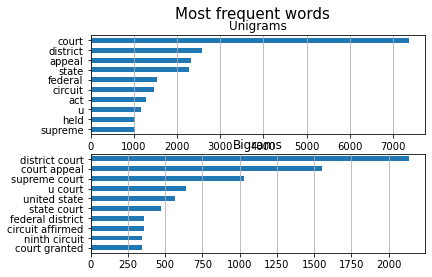

In [26]:
# выбираем ВЫИГРАННЫЕ истцом дела, делаем из них новый corpus_1:
y = 1
corpus_1 = df_nlp2[df_nlp2["first_party_winner"]== y]["facts_clean"]
print(corpus_1.head(4))

# снова проводим токенизацию:
lst_tokens = nltk.tokenize.word_tokenize(corpus_1.str.cat(sep=" "))

# Визуализируем:
fig, ax = plt.subplots(nrows=2, ncols=1)
fig.suptitle("Most frequent words", fontsize=15)
#figure(figsize=(30, 24))

## unigrams - разбиваем по одному слову:
dic_words_freq = nltk.FreqDist(lst_tokens)
dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                       columns=["Word","Freq"])
dtf_uni.set_index("Word").iloc[:10,:].sort_values(by="Freq").plot(
                  kind="barh", title="Unigrams", ax=ax[0], 
                  legend=False).grid(axis='x')
ax[0].set(ylabel=None)
    
## bigrams - разбиваем по 2 слова:
dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
dtf_bi = pd.DataFrame(dic_words_freq.most_common(), 
                      columns=["Word","Freq"])
dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(
                   string for string in x) )
dtf_bi.set_index("Word").iloc[:10,:].sort_values(by="Freq").plot(
                  kind="barh", title="Bigrams", ax=ax[1],
                  legend=False).grid(axis='x')
ax[1].set(ylabel=None)
# смотрим графики:
plt.show()

6     william baird gave away emko vaginal foam woma...
7     georgia state court convicted johnny wilson vi...
10    observing interviewing number people synthesiz...
11    william shard reported chicago police two men ...
Name: facts_clean, dtype: object


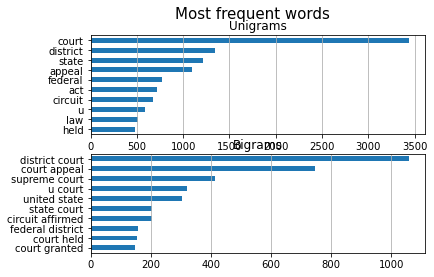

In [27]:
# выбираем ПРОИГРАННЫЕ истцом дела, делаем из них новый corpus_0:
y = 0
corpus_0 = df_nlp2[df_nlp2["first_party_winner"]== y]["facts_clean"]
print(corpus_0.head(4))

# снова проводим токенизацию:
lst_tokens = nltk.tokenize.word_tokenize(corpus_0.str.cat(sep=" "))

# Визуализируем:
fig, ax = plt.subplots(nrows=2, ncols=1)
fig.suptitle("Most frequent words", fontsize=15)
#figure(figsize=(30, 24))

## unigrams - разбиваем по одному слову:
dic_words_freq = nltk.FreqDist(lst_tokens)
dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                       columns=["Word","Freq"])
dtf_uni.set_index("Word").iloc[:10,:].sort_values(by="Freq").plot(
                  kind="barh", title="Unigrams", ax=ax[0], 
                  legend=False).grid(axis='x')
ax[0].set(ylabel=None)
    
## bigrams - разбиваем по 2 слова:
dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
dtf_bi = pd.DataFrame(dic_words_freq.most_common(), 
                      columns=["Word","Freq"])
dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(
                   string for string in x) )
dtf_bi.set_index("Word").iloc[:10,:].sort_values(by="Freq").plot(
                  kind="barh", title="Bigrams", ax=ax[1],
                  legend=False).grid(axis='x')
ax[1].set(ylabel=None)
# смотрим графики:
plt.show()

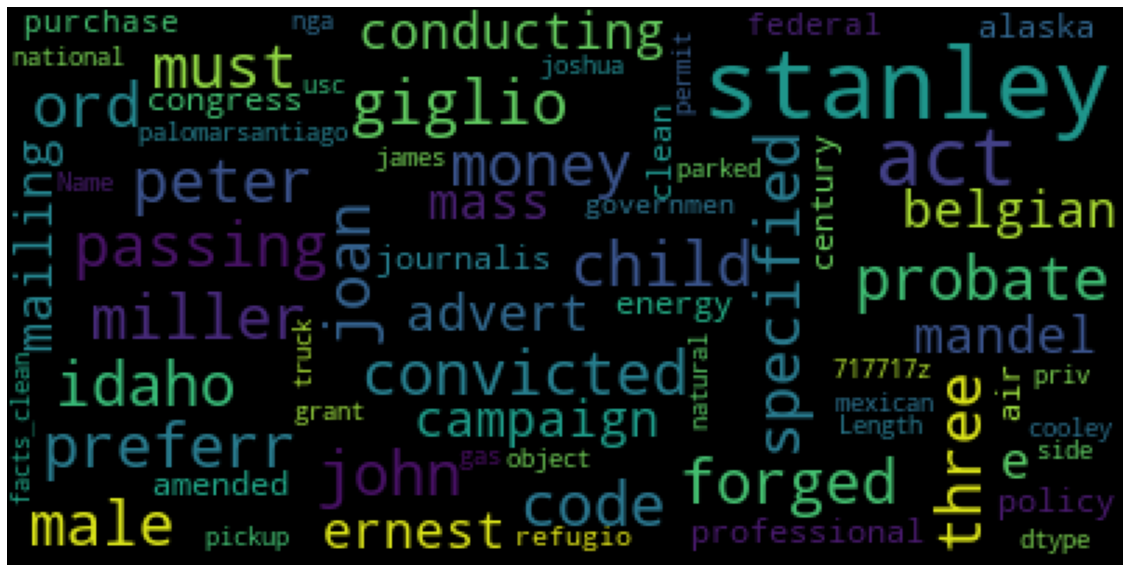

In [28]:
wc = wordcloud.WordCloud(background_color='black', max_words=100, 
                         max_font_size=35)
wc_1 = wc.generate(str(corpus_1))
fig = plt.figure(figsize=(20,15), num=1)
plt.axis('off')
plt.imshow(wc_1, cmap=None)
plt.show()

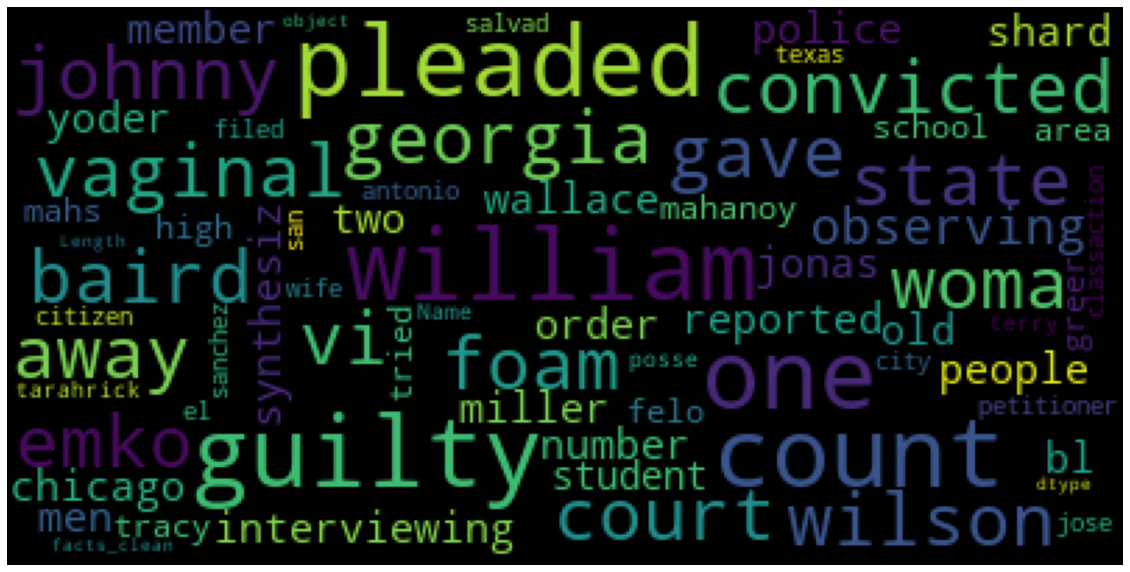

In [29]:
wc_0 = wc.generate(str(corpus_0))
fig = plt.figure(figsize=(20,15),num=1)
plt.axis('off')
plt.imshow(wc_0, cmap=None)
plt.show()

### main topics - LDAModel

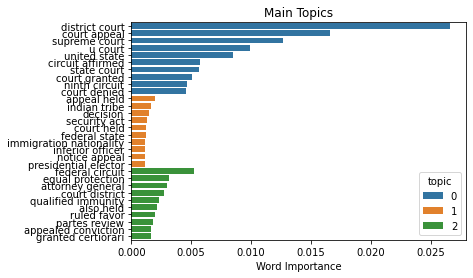

In [30]:
# выбираем ВЫИГРАННЫЕ истцом дела:
y = 1
corpus = df_nlp2[df_nlp2["first_party_winner"]==y]["facts_clean"]
# препрцессинг:
lst_corpus = []
for string in corpus:
    lst_words = string.split() # разбиваем на слова
    lst_grams = [" ".join(lst_words[i:i+2]) for i in range(0, len(lst_words), 2)] # делаем 2-gram (bigram-ы)
    lst_corpus.append(lst_grams) 
# сопоставим слова с id:
id2word = gensim.corpora.Dictionary(lst_corpus)
# сделаем словарь word:freq
dic_corpus = [id2word.doc2bow(word) for word in lst_corpus] 
# тренируем модель LDA:
lda_model = gensim.models.ldamodel.LdaModel(corpus=dic_corpus, id2word=id2word, num_topics=7, random_state=123, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
   
# выход модели:
lst_dics = []
for i in range(0,3):
    lst_tuples = lda_model.get_topic_terms(i)
    for tupla in lst_tuples:
        lst_dics.append({"topic":i, "id":tupla[0], 
                         "word":id2word[tupla[0]], 
                         "weight":tupla[1]})
dtf_topics = pd.DataFrame(lst_dics, 
                         columns=['topic','id','word','weight'])

# визуализируем:
fig, ax = plt.subplots()
sns.barplot(y="word", x="weight", hue="topic", data=dtf_topics, dodge=False, ax=ax).set_title('Main Topics')
ax.set(ylabel="", xlabel="Word Importance")
plt.show()

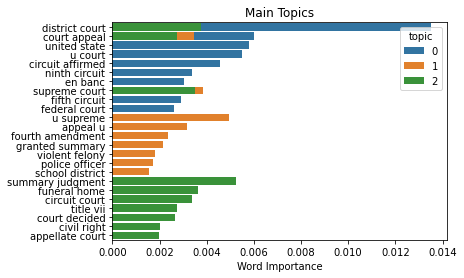

In [31]:
# выбираем ПРОИГРАННЫЕ истцом дела:
y = 0
corpus = df_nlp2[df_nlp2["first_party_winner"]==y]["facts_clean"]
# препрцессинг:
lst_corpus = []
for string in corpus:
    lst_words = string.split() # разбиваем на слова
    lst_grams = [" ".join(lst_words[i:i + 2]) for i in range(0,len(lst_words), 2)] # делаем 2-gram (bigram-ы)
    lst_corpus.append(lst_grams)
# сопоставим слова с id:
id2word = gensim.corpora.Dictionary(lst_corpus)
# сделаем словарь word:freq
dic_corpus = [id2word.doc2bow(word) for word in lst_corpus]
# тренируем модель LDA:
lda_model = gensim.models.ldamodel.LdaModel(corpus=dic_corpus, id2word=id2word, num_topics=7, random_state=123, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
   
# выход модели:
lst_dics = []
for i in range(0,3):
    lst_tuples = lda_model.get_topic_terms(i)
    for tupla in lst_tuples:
        lst_dics.append({"topic":i, "id":tupla[0], 
                         "word":id2word[tupla[0]], 
                         "weight":tupla[1]})
dtf_topics = pd.DataFrame(lst_dics, 
                         columns=['topic','id','word','weight'])

# визуализируем:
fig, ax = plt.subplots()
sns.barplot(y="word", x="weight", hue="topic", data=dtf_topics, dodge=False, ax=ax).set_title('Main Topics')
ax.set(ylabel="", xlabel="Word Importance")
plt.show()

### df_nlp2

In [32]:
df_nlp1

,facts,facts_clean
0,Joan Stanley had three children with Peter Sta...,joan stanley three child peter stanley stanley...
1,John Giglio was convicted of passing forged mo...,john giglio convicted passing forged money ord...
2,"The Idaho Probate Code specified that ""males m...",idaho probate code specified male must preferr...
3,"Miller, after conducting a mass mailing campai...",miller conducting mass mailing campaign advert...
4,Ernest E. Mandel was a Belgian professional jo...,ernest e mandel belgian professional journalis...
...,...,...
3093,For over a century after the Alaska Purchase i...,century alaska purchase 1867 federal governmen...
3094,"Refugio Palomar-Santiago, a Mexican national, ...",refugio palomarsantiago mexican national grant...
3095,Tarahrick Terry pleaded guilty to one count of...,tarahrick terry pleaded guilty one count posse...
3096,Joshua James Cooley was parked in his pickup t...,joshua james cooley parked pickup truck side r...


In [33]:
df_nlp1['facts'][0]

'Joan Stanley had three children with Peter Stanley.  The Stanleys never married, but lived together off and on for 18 years.  When Joan died, the State of Illinois took the children.  Under Illinois law, unwed fathers were presumed unfit parents regardless of their actual fitness and their children became wards of the state.  Peter appealed the decision, arguing that the Illinois law violated the Equal Protection Clause of the Fourteenth Amendment because unwed mothers were not deprived of their children without a showing that they were actually unfit parents.  The Illinois Supreme Court rejected Stanley’s Equal Protection claim, holding that his actual fitness as a parent was irrelevant because he and the children’s mother were unmarried.\n'

In [34]:
# для преобразования текста в матрицу количества токенов:
vectorizer = CountVectorizer()

In [35]:
# объединяем df с очщенным текстом с таргетной переменной:
df_nlp2 = pd.concat([df_nlp1,df_target1['first_party_winner']],axis=1, join='inner')
df_nlp2

,facts,facts_clean,first_party_winner
0,Joan Stanley had three children with Peter Sta...,joan stanley three child peter stanley stanley...,1
1,John Giglio was convicted of passing forged mo...,john giglio convicted passing forged money ord...,1
2,"The Idaho Probate Code specified that ""males m...",idaho probate code specified male must preferr...,1
3,"Miller, after conducting a mass mailing campai...",miller conducting mass mailing campaign advert...,1
4,Ernest E. Mandel was a Belgian professional jo...,ernest e mandel belgian professional journalis...,1
...,...,...,...
3093,For over a century after the Alaska Purchase i...,century alaska purchase 1867 federal governmen...,1
3094,"Refugio Palomar-Santiago, a Mexican national, ...",refugio palomarsantiago mexican national grant...,1
3095,Tarahrick Terry pleaded guilty to one count of...,tarahrick terry pleaded guilty one count posse...,0
3096,Joshua James Cooley was parked in his pickup t...,joshua james cooley parked pickup truck side r...,1


In [36]:
# разделяем на фичи (x) и таргет (лейбл или y):
xfeatures = df_nlp2['facts_clean']
ylabel = df_nlp2['first_party_winner']

In [37]:
type(xfeatures[0])

str

### split

In [38]:
# делим на train и test: 0.75:0.25
X_train, X_test, y_train, y_test = train_test_split(xfeatures,ylabel, test_size=0.25)

In [39]:
X_test

93      julian vella seaman s robert macnamara suffere...
777     karl oberg driving allterrain vehicle overturn...
2586    sam ginsberg wife operated sam stationary lunc...
2922    2011 victor stitt tried shove loaded handgun g...
1535    david nelson sentenced death murder scheduled ...
                              ...                        
1795    meadwestvaco ohio company sold lucrative lexis...
1503    juan davila sued hmo state court refused provi...
1175    hawaiian constitution limit right vote nine tr...
141     american mini theater opened two theater showe...
2525    november 22 1950 attorney general petitioned s...
Name: facts_clean, Length: 775, dtype: object

### Pipeline c LogisticRegression, score = 0.599

In [36]:
# задаём пайплайн с LogisticRegression():
pipe = Pipeline(steps=[('cv',CountVectorizer()),('lr',LogisticRegression(solver='liblinear'))])
# загружаем данные в модель ("фитим")
pipe.fit(X_train,y_train)
# смотрим точность:
print('Score LogisticRegression() на train:',pipe.score(X_train,y_train))
print('Score LogisticRegression() на test:', pipe.score(X_test,y_test))

Score LogisticRegression() на train: 0.9995695221696083
Score LogisticRegression() на test: 0.5870967741935483


### Pipeline c RandomForestClassifier, score = 0.651

In [138]:
# делаем всё то же самое, но с RandomForestClassifier():
pipe1= Pipeline(steps=[('cv',CountVectorizer()),('rf',RandomForestClassifier())])
pipe1.fit(X_train,y_train)
print('Score RandomForestClassifier() на train:',pipe1.score(X_train,y_train))
print('Score RandomForestClassifier() на test:', pipe1.score(X_test,y_test))

Score RandomForestClassifier() на train: 1.0
Score RandomForestClassifier() на test: 0.6748387096774193


### Pipeline c KNeighborsClassifier, score = 0.613

In [38]:
# делаем всё то же самое, но с KNeighborsClassifier()
pipe2= Pipeline(steps=[('cv',CountVectorizer()),('rf',KNeighborsClassifier(n_neighbors=3))])
pipe2.fit(X_train,y_train)
Pipeline(steps=[('cv', CountVectorizer()),('rf', KNeighborsClassifier(n_neighbors=3))])
print('Score KNeighborsClassifier() на train:', pipe2.score(X_train,y_train))
print('Score KNeighborsClassifier() на test:', pipe2.score(X_test,y_test))

Score KNeighborsClassifier() на train: 0.7606543263021954
Score KNeighborsClassifier() на test: 0.6348387096774194


## наши данные

In [40]:
max(df_nlp2['facts_clean'])

'yuehshaio yang wife former taiwan resident executed elaborate fraudulent scheme gain entry united state later obtain yang citizenship yang naturalization application pending immigration naturalization service in learned unlawful entry issued order show cause deported time entry yang conceded deportable filed request waiver deportation immigration nationality act attorney general immigration judge denied yang request affirming board immigration appeal found yang statutorily eligible waiver denied matter discretion vacating court appeal held board abused discretion considering adverse factor yang participation wife fraudulent entry secondly fraudulent naturalization application court reasoned yang action wife fraudulent entry inextricably intertwined effort secure entry must considered part initial fraud application must considered extension initial fraud'

In [41]:
example_text = {'example_fact': 'immigration nationality cause deported time entry yang conceded effort secure entry must deportable filed request waiver deportation immigration nationality act attorney general immigration judge'}
example_fact_clean = pd.DataFrame(data=example_text, index=[0])
example_fact_clean
example_X_test = example_fact_clean['example_fact']
example_X_test

0    immigration nationality cause deported time en...
Name: example_fact, dtype: object

In [140]:
# # делаем всё то же самое, но с RandomForestClassifier():
# pipe1= Pipeline(steps=[('cv',CountVectorizer()),('rf',RandomForestClassifier())])
# pipe1.fit(X_train,y_train)
# print('Score RandomForestClassifier() на train:',pipe1.score(X_train,y_train))
# print('Score RandomForestClassifier() на test:', pipe1.score(X_test,y_test))

ex_pred = pipe1.predict(example_X_test)
ex_pred

array([1])

In [42]:
# dump(pipe1, 'pipe1.pkl')
pipeline_RFC = joblib.load('pipe1.pkl')
ex_pred_RFC = pipeline_RFC.predict(example_X_test)
ex_pred_RFC

array([1])

## попробуем свой пайплайн?

In [43]:
# ищем 
trying_pipeline= Pipeline(steps=[('cv',CountVectorizer()),('rf',RandomForestClassifier())])
parameters = {'rf__n_estimators': [i for i in range(100, 151)],
              'rf__max_depth': [i for i in range(2, 9)],
              'rf__min_samples_split': [i for i in range(2, 9)]
              }
gs_cv = GridSearchCV(trying_pipeline, param_grid=parameters, cv=3, verbose=1)
gs_cv.fit(X_train, y_train)


Fitting 3 folds for each of 2499 candidates, totalling 7497 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__max_depth': [2, 3, 4, 5, 6, 7, 8],
                         'rf__min_samples_split': [2, 3, 4, 5, 6, 7, 8],
                         'rf__n_estimators': [100, 101, 102, 103, 104, 105, 106,
                                              107, 108, 109, 110, 111, 112, 113,
                                              114, 115, 116, 117, 118, 119, 120,
                                              121, 122, 123, 124, 125, 126, 127,
                                              128, 129, ...]},
             verbose=1)

In [44]:
gs_cv.best_params_
# {'rf__max_depth': 2,
#  'rf__min_samples_leaf': 1,
#  'rf__min_samples_split': 2,
#  'rf__n_estimators': 100}

{'rf__max_depth': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}

In [57]:
trying_pipeline= Pipeline(steps=[('cv',CountVectorizer()),
                                ('rf',RandomForestClassifier(max_depth=2,
                                                            min_samples_split=2,
                                                            n_estimators=100,
                                                            min_samples_leaf=1,
                                                            class_weight={1:0.333, 0:0.667}))])
# загружаем данные в модель ("фитим")
trying_pipeline.fit(X_train,y_train)
# смотрим точность:
print('Score RandomForestClassifier() на train:',trying_pipeline.score(X_train,y_train))
print('Score RandomForestClassifier() на test:', trying_pipeline.score(X_test,y_test))

Score RandomForestClassifier() на train: 0.7430047352561343
Score RandomForestClassifier() на test: 0.6309677419354839


In [59]:
# dump(trying_pipeline, 'pipeline_RFC_2.pkl')
pipeline_RFC_2 = joblib.load('pipeline_RFC_2.pkl')
ex_pred_RFC_2 = pipeline_RFC_2.predict(example_X_test)
ex_pred_RFC_2

array([1])

# вар2 - с one-hot encoded фичами

In [39]:
# теперь посмотрим, какой score будет, если использовать также и фичи 'decision_type' (вид принятия решения) и 'disposition'(окончательное решение суда по обвинению)
df_nl1=pd.concat([df_nlp2,df_cat],axis=1,join='inner')

In [40]:
df_nl1

,facts,facts_clean,first_party_winner,decision_type,disposition
0,Joan Stanley had three children with Peter Sta...,joan stanley three child peter stanley stanley...,1,majority opinion,reversed/remanded
1,John Giglio was convicted of passing forged mo...,john giglio convicted passing forged money ord...,1,majority opinion,reversed/remanded
2,"The Idaho Probate Code specified that ""males m...",idaho probate code specified male must preferr...,1,majority opinion,reversed/remanded
3,"Miller, after conducting a mass mailing campai...",miller conducting mass mailing campaign advert...,1,majority opinion,vacated/remanded
4,Ernest E. Mandel was a Belgian professional jo...,ernest e mandel belgian professional journalis...,1,majority opinion,reversed
...,...,...,...,...,...
3093,For over a century after the Alaska Purchase i...,century alaska purchase 1867 federal governmen...,1,majority opinion,reversed/remanded
3094,"Refugio Palomar-Santiago, a Mexican national, ...",refugio palomarsantiago mexican national grant...,1,majority opinion,reversed/remanded
3095,Tarahrick Terry pleaded guilty to one count of...,tarahrick terry pleaded guilty one count posse...,0,majority opinion,affirmed
3096,Joshua James Cooley was parked in his pickup t...,joshua james cooley parked pickup truck side r...,1,majority opinion,vacated/remanded


In [41]:
# выделяем фичи и таргет:
xfeatures1 = df_nl1[['facts_clean','decision_type','disposition']]
ylabel1 = df_nl1['first_party_winner']

In [42]:
# делаем one-hot-encoding 'decision_type', 'disposition' и конкатенируем в одну df - вместе с таргетом:
df_cat1 = pd.get_dummies(df_cat['decision_type'])
df_cat2 = pd.get_dummies(df_cat['disposition'])
df_cat3=pd.concat([df_cat2,df_cat1],axis=1,join='inner')
df_cat3=pd.concat([df_cat3,df_nl1['first_party_winner']],axis=1,join='inner')

In [60]:
df_cat3

,affirmed,none,reversed,reversed in-part,reversed in-part/remanded,reversed/remanded,vacated,vacated in-part/remanded,vacated/remanded,dismissal - improvidently granted,dismissal - moot,dismissal - other,equally divided,majority opinion,opinion of the court,per curiam,plurality opinion,first_party_winner
0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
2,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
3,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
4,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3093,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
3094,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
3095,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3096,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1


In [43]:
df_cat3.columns

Index(['affirmed', 'none', 'reversed', 'reversed in-part',
       'reversed in-part/remanded', 'reversed/remanded', 'vacated',
       'vacated in-part/remanded', 'vacated/remanded',
       'dismissal - improvidently granted', 'dismissal - moot',
       'dismissal - other', 'equally divided', 'majority opinion',
       'opinion of the court', 'per curiam', 'plurality opinion',
       'first_party_winner'],
      dtype='object')

### df_nl1, уникальные значения и текст 

In [57]:
df_nl1

,facts,facts_clean,first_party_winner,decision_type,disposition
0,Joan Stanley had three children with Peter Sta...,joan stanley three child peter stanley stanley...,1,majority opinion,reversed/remanded
1,John Giglio was convicted of passing forged mo...,john giglio convicted passing forged money ord...,1,majority opinion,reversed/remanded
2,"The Idaho Probate Code specified that ""males m...",idaho probate code specified male must preferr...,1,majority opinion,reversed/remanded
3,"Miller, after conducting a mass mailing campai...",miller conducting mass mailing campaign advert...,1,majority opinion,vacated/remanded
4,Ernest E. Mandel was a Belgian professional jo...,ernest e mandel belgian professional journalis...,1,majority opinion,reversed
...,...,...,...,...,...
3093,For over a century after the Alaska Purchase i...,century alaska purchase 1867 federal governmen...,1,majority opinion,reversed/remanded
3094,"Refugio Palomar-Santiago, a Mexican national, ...",refugio palomarsantiago mexican national grant...,1,majority opinion,reversed/remanded
3095,Tarahrick Terry pleaded guilty to one count of...,tarahrick terry pleaded guilty one count posse...,0,majority opinion,affirmed
3096,Joshua James Cooley was parked in his pickup t...,joshua james cooley parked pickup truck side r...,1,majority opinion,vacated/remanded


In [58]:
pd.unique(df_nl1['decision_type'])

array(['majority opinion', 'per curiam', 'plurality opinion',
       'equally divided', 'dismissal - moot',
       'dismissal - improvidently granted', 'dismissal - other',
       'opinion of the court'], dtype=object)

In [59]:
pd.unique(df_nl1['disposition'])

array(['reversed/remanded', 'vacated/remanded', 'reversed', 'affirmed',
       'reversed in-part', 'reversed in-part/remanded', 'vacated', 'none',
       'vacated in-part/remanded'], dtype=object)

### data_final

In [44]:
# embedding колонки 'facts_clean' и делаем матрицу встречаемости всех слов во всех делах (bag of words):
vectorize=CountVectorizer()
count_matrix = vectorize.fit_transform(df_nl1['facts_clean'])
count_array = count_matrix.toarray()
data_final = pd.DataFrame(data=count_array,columns = vectorize.get_feature_names())
data_final = pd.concat([data_final,df_cat3],axis=1,join='inner')

/home/marina/miniforge3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [45]:
data_final
# data_final.to_csv('/content/drive/MyDrive/My_Notebooks/RANEPA/judgement_prediction/data_final.csv')
# data_final = pd.read_csv('/content/drive/MyDrive/My_Notebooks/RANEPA/judgement_prediction/data_final.csv')

,011119,0125,01657,019,02,036539,04,041352,041581,045323,...,vacated/remanded,dismissal - improvidently granted,dismissal - moot,dismissal - other,equally divided,majority opinion,opinion of the court,per curiam,plurality opinion,first_party_winner
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3093,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3094,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3095,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3096,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1


### split

In [46]:
# делим data_final на train (X и y) test (X и y):
X_train, X_test, y_train, y_test = train_test_split(data_final.drop(columns=['first_party_winner']), 
                                                    data_final['first_party_winner'], 
                                                    test_size=0.3,
                                                    random_state=10)

In [47]:
y_train

2980    1
2874    1
869     0
299     0
2039    1
       ..
2009    1
1180    0
1344    1
527     1
1289    0
Name: first_party_winner, Length: 2168, dtype: int64

In [48]:
# ЗАЧЕМ, если дальше не используем???
scaler = StandardScaler()
data_final = scaler.fit_transform(data_final)

In [49]:
data_final

array([[-0.01796923, -0.01796923, -0.01796923, ..., -0.27034468,
        -0.22159108,  0.70625103],
       [-0.01796923, -0.01796923, -0.01796923, ..., -0.27034468,
        -0.22159108,  0.70625103],
       [-0.01796923, -0.01796923, -0.01796923, ..., -0.27034468,
        -0.22159108,  0.70625103],
       ...,
       [-0.01796923, -0.01796923, -0.01796923, ..., -0.27034468,
        -0.22159108, -1.41592714],
       [-0.01796923, -0.01796923, -0.01796923, ..., -0.27034468,
        -0.22159108,  0.70625103],
       [-0.01796923, -0.01796923, -0.01796923, ..., -0.27034468,
        -0.22159108,  0.70625103]])

## Performing LDA and hyper-parameter tuning

In [50]:
# Латентное размещение Дирихле для выявления причин сходства некоторых частей данных:
# lda = LatentDirichletAllocation(n_components=200, random_state=0, learning_method="online") # learning_method="batch"
# lda_data = lda.fit_transform(X_train)

In [51]:
# lda_data_train = pd.DataFrame(data=lda.fit_transform(X_train))
# lda_data_train.to_csv('/content/drive/MyDrive/My_Notebooks/RANEPA/judgement_prediction/lda_data_train.csv')
lda_data_train = pd.read_csv('lda_data_train.csv') #/content/drive/MyDrive/My_Notebooks/RANEPA/judgement_prediction/

In [52]:
# lda_data_test = pd.DataFrame(data=lda.transform(X_test))
# lda_data_test.to_csv('/content/drive/MyDrive/My_Notebooks/RANEPA/judgement_prediction/lda_data_test.csv')
lda_data_test = pd.read_csv('lda_data_test.csv') #/content/drive/MyDrive/My_Notebooks/RANEPA/judgement_prediction/

In [89]:
lda_data_test

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,190,191,192,193,194,195,196,197,198,199
0,0,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,...,0.000033,0.007997,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033
1,1,0.000036,0.000036,0.000036,0.000036,0.000036,0.000036,0.000036,0.000036,0.000036,...,0.000036,0.000036,0.000036,0.000036,0.000036,0.000036,0.000036,0.000036,0.000036,0.000036
2,2,0.000037,0.000037,0.000037,0.000037,0.000037,0.000037,0.000037,0.000037,0.000037,...,0.000037,0.004604,0.000037,0.000037,0.000037,0.000037,0.000037,0.000037,0.000037,0.000037
3,3,0.000055,0.000055,0.000055,0.000055,0.000055,0.000055,0.000055,0.000055,0.000055,...,0.000055,0.000055,0.000055,0.000055,0.000055,0.000055,0.000055,0.000055,0.000055,0.000055
4,4,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,...,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,925,0.000185,0.000185,0.000185,0.000185,0.000185,0.000185,0.000185,0.000185,0.000185,...,0.000185,0.000185,0.000185,0.000185,0.000185,0.000185,0.000185,0.000185,0.000185,0.000185
926,926,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,...,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042
927,927,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,...,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.088882
928,928,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,...,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043


### GridSearch - не запускать!!!

In [68]:
# da_data_test = pd.DataFrame(data=lda.transform(X_test)) # ???
# Create the parameter grid based on the results of random search 

param_grid = {
    'max_depth': [8,10,12,14],
    'max_features': [60,70,80,90,100],
    'min_samples_leaf': [2, 3, 4],
    'n_estimators': [100, 200, 300]
}# Create a based model
rf = RandomForestClassifier()# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
grid_search.fit(lda_data_train, y_train)
grid_search.best_params_
# rand=RandomForestClassifier(max_depth= 8, max_features = 100, min_samples_leaf = 2, n_estimators = 200)

Fitting 3 folds for each of 180 candidates, totalling 540 fits


{'max_depth': 8,
 'max_features': 60,
 'min_samples_leaf': 3,
 'n_estimators': 200}

### RandomForestClassifier, score=0.666, f1-score=0.799

In [64]:
# возьмём модель RandomForestClassifier():
rand=RandomForestClassifier(max_depth= 8, max_features = 60, min_samples_leaf = 3, n_estimators = 200)
rand.fit(lda_data_train,y_train)
print('Score RandomForestClassifier() на train:', rand.score(lda_data_train,y_train))  #0.7135608856088561
print('Score RandomForestClassifier() на test:', rand.score(lda_data_test,y_test))  #0.6666666666666666
y_pred1 = rand.predict(lda_data_test)
print('f1_score на test:', f1_score(y_test, y_pred1)) #0.7994825355756792

Score RandomForestClassifier() на train: 0.6974169741697417
Score RandomForestClassifier() на test: 0.667741935483871
f1_scoreна test: 0.8002585649644474


### XGBClassifier: acc=66.88%, f1-score=0.799

In [53]:
# возьмём модель XGBClassifier():
model_XGBC = XGBClassifier()
model_XGBC.fit(lda_data_train, y_train)
y_pred = model_XGBC.predict(lda_data_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('f1_score на test:', f1_score(y_test, y_pred)) # было Accuracy: 66.88%    0.7994825355756792

/home/marina/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marina/miniforge3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[09:05:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 63.33%
f1_score на test: 0.7579843860894251


### от М.В.: acc=67.10%, f1-score=0.799

In [56]:
# возьмём модель CatBoostClassifier():
model_CB = CatBoostClassifier(learning_rate=0.01433401) 
#0.014334 Accuracy: Accuracy: 66.77% 0.7994825355756792 0.01433401 Accuracy: 67.10% 0.7994825355756792
model_CB.fit(lda_data_train, y_train)
y_pred = model_CB.predict(lda_data_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
f1_score(y_test, y_pred) # было Accuracy: 67.10%   0.7994825355756792

0:	learn: 0.6914327	total: 128ms	remaining: 2m 8s
1:	learn: 0.6897381	total: 258ms	remaining: 2m 8s
2:	learn: 0.6881100	total: 371ms	remaining: 2m 3s
3:	learn: 0.6864777	total: 505ms	remaining: 2m 5s
4:	learn: 0.6849296	total: 684ms	remaining: 2m 16s
5:	learn: 0.6834555	total: 901ms	remaining: 2m 29s
6:	learn: 0.6819519	total: 1.05s	remaining: 2m 29s
7:	learn: 0.6805623	total: 1.17s	remaining: 2m 24s
8:	learn: 0.6792173	total: 1.36s	remaining: 2m 29s
9:	learn: 0.6777828	total: 1.48s	remaining: 2m 26s
10:	learn: 0.6764999	total: 1.59s	remaining: 2m 22s
11:	learn: 0.6752683	total: 1.71s	remaining: 2m 20s
12:	learn: 0.6740687	total: 1.8s	remaining: 2m 16s
13:	learn: 0.6729255	total: 1.9s	remaining: 2m 13s
14:	learn: 0.6716728	total: 1.98s	remaining: 2m 10s
15:	learn: 0.6705856	total: 2.09s	remaining: 2m 8s
16:	learn: 0.6694385	total: 2.19s	remaining: 2m 6s
17:	learn: 0.6682619	total: 2.31s	remaining: 2m 6s
18:	learn: 0.6672053	total: 2.43s	remaining: 2m 5s
19:	learn: 0.6661169	total: 2.51

0.7947194719471947

## наши данные ---

In [69]:
max(df_nl1['facts_clean'])

'yuehshaio yang wife former taiwan resident executed elaborate fraudulent scheme gain entry united state later obtain yang citizenship yang naturalization application pending immigration naturalization service in learned unlawful entry issued order show cause deported time entry yang conceded deportable filed request waiver deportation immigration nationality act attorney general immigration judge denied yang request affirming board immigration appeal found yang statutorily eligible waiver denied matter discretion vacating court appeal held board abused discretion considering adverse factor yang participation wife fraudulent entry secondly fraudulent naturalization application court reasoned yang action wife fraudulent entry inextricably intertwined effort secure entry must considered part initial fraud application must considered extension initial fraud'

In [ ]:
# Виды decision_type
# ['majority opinion', 'per curiam', 'plurality opinion',
# 'equally divided', 'dismissal - moot',
# 'dismissal - improvidently granted', 'dismissal - other',
# 'opinion of the court']

In [ ]:
# Виды disposition
# ['reversed/remanded', 'vacated/remanded', 'reversed', 'affirmed',
# 'reversed in-part', 'reversed in-part/remanded', 'vacated', 'none',
# 'vacated in-part/remanded']

### свои 'example_decision_type'и 'example_disposition'

In [79]:
example = {'example_decision_type': 'majority opinion',
            'example_disposition': 'affirmed'}
example_cat = pd.DataFrame(data=example, index=[0])
example_cat

,example_decision_type,example_disposition
0,majority opinion,affirmed


In [81]:
example_cat1 = pd.get_dummies(example_cat['example_decision_type'])
example_cat2 = pd.get_dummies(example_cat['example_disposition'])
example_cat3=pd.concat([example_cat2,example_cat1],axis=1,join='inner')
# example_cat3=pd.concat([df_cat3,df_nl1['first_party_winner']],axis=1,join='inner')
example_cat3

,affirmed,majority opinion
0,1,1


### свои example_fact

In [82]:
example_text = {'example_fact': 'immigration nationality cause deported time entry yang conceded effort secure entry must deportable filed request waiver deportation immigration nationality act attorney general immigration judge'}
example_fact = pd.DataFrame(data=example_text, index=[0])
example_fact

,example_fact
0,immigration nationality cause deported time en...


In [85]:
vectorize=CountVectorizer()
example_count_matrix = vectorize.fit_transform(example_fact['example_fact'])
example_count_array = example_count_matrix.toarray()
example_data_final = pd.DataFrame(data=example_count_array,columns = vectorize.get_feature_names())
example_data_final = pd.concat([example_data_final,example_cat3],axis=1,join='inner')
example_data_final

/home/marina/miniforge3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,act,attorney,cause,conceded,deportable,deportation,deported,effort,entry,filed,...,judge,must,nationality,request,secure,time,waiver,yang,affirmed,majority opinion
0,1,1,1,1,1,1,1,1,2,1,...,1,1,2,1,1,1,1,1,1,1


### дирихле

In [87]:
example_X_test = example_data_final

In [90]:
# Латентное размещение Дирихле для выявления причин сходства некоторых частей данных:
lda = LatentDirichletAllocation(n_components=200, random_state=0, learning_method="online") # learning_method="batch"
lda_data_train = pd.DataFrame(data=lda.fit_transform(X_train))
# lda_data_train.to_csv('/content/drive/MyDrive/My_Notebooks/RANEPA/judgement_prediction/lda_data_train.csv')
# lda_data_train = pd.read_csv('lda_data_train.csv') #/content/drive/MyDrive/My_Notebooks/RANEPA/judgement_prediction/

example_lda_data_test = pd.DataFrame(data=lda.transform(example_X_test))
# example_lda_data_test.to_csv('/content/drive/MyDrive/My_Notebooks/RANEPA/judgement_prediction/lda_data_test.csv')
# example_lda_data_test = pd.read_csv('lda_data_test.csv') #/content/drive/MyDrive/My_Notebooks/RANEPA/judgement_prediction/

/home/marina/miniforge3/lib/python3.9/site-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- 011119
- 0125
- 01657
- 019
- 02
- ...

  warnings.warn(message, FutureWarning)


ValueError: X has 22 features, but LatentDirichletAllocation is expecting 20268 features as input.

In [ ]:
# from joblib import dump, load
# dump(model_XGBC, 'model_XGBC.joblib') 

clf = load('model_XGBC.joblib') 

model_XGBC = XGBClassifier()
model_XGBC.fit(lda_data_train, y_train)
y_pred = model_XGBC.predict(lda_data_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('f1_score на test:', f1_score(y_test, y_pred)) # было Accuracy: 66.88%    0.7994825355756792